# SciDTB Exploratory Data Analysis

This notebook performs comprehensive exploratory data analysis on the SciDTB discourse dependency treebank.

## Contents
1. Data Loading
2. Basic Statistics
3. EDU Analysis
4. Discourse Relations
5. Tree Structure Analysis
6. Dependency Distance
7. Relation Co-occurrence
8. Visualizations

In [1]:
# Setup
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent))

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from typing import List, Dict
import warnings

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Import project modules
from src.data.loader import SciDTBLoader
from src.models import DiscourseTreeModel

print("✓ Imports successful")

✓ Imports successful


## 1. Data Loading

In [3]:
# Load data
data_dir = Path("data/raw")
loader = SciDTBLoader(data_dir)

# Load all splits
train_trees = loader.load_split("train")
test_trees = loader.load_split("test/gold")

all_trees = train_trees + test_trees

print(f"Loaded {len(train_trees)} training trees")
print(f"Loaded {len(test_trees)} test trees")
print(f"Total: {len(all_trees)} trees")

Error loading data\raw\train\P16-1069_anno2.edu.txt.dep: 1 validation error for DiscourseTreeModel
edus
  Value error, Must have exactly one ROOT EDU, found 2 [type=value_error, input_value=[EDUModel(id=0, text='ROO... relation='evaluation')], input_type=list]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error
Error loading data\raw\test\gold\D14-1042.edu.txt.dep: 1 validation error for DiscourseTreeModel
edus
  Value error, Must have exactly one ROOT EDU, found 2 [type=value_error, input_value=[EDUModel(id=0, text='ROO... relation='evaluation')], input_type=list]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error


Loaded 742 training trees
Loaded 151 test trees
Total: 893 trees


## 2. Basic Statistics

In [4]:
def compute_basic_stats(trees: List[DiscourseTreeModel]) -> pd.DataFrame:
    """
    Compute basic statistics about the corpus.
    """
    stats = {
        'num_edus': [],
        'num_relations': [],
        'tree_depth': [],
        'avg_text_length': []
    }
    
    for tree in trees:
        # Number of EDUs (excluding ROOT)
        non_root_edus = [edu for edu in tree.edus if edu.id != 0]
        stats['num_edus'].append(len(non_root_edus))
        
        # Number of relations (excluding ROOT relation)
        relations = [edu.relation for edu in non_root_edus if edu.relation != 'ROOT']
        stats['num_relations'].append(len(relations))
        
        # Tree depth
        depths = []
        for edu in non_root_edus:
            depth = 0
            current_id = edu.parent
            while current_id != -1:
                depth += 1
                parent_edu = next((e for e in tree.edus if e.id == current_id), None)
                if parent_edu:
                    current_id = parent_edu.parent
                else:
                    break
            depths.append(depth)
        stats['tree_depth'].append(max(depths) if depths else 0)
        
        # Average text length
        text_lengths = [len(edu.text.split()) for edu in non_root_edus]
        stats['avg_text_length'].append(np.mean(text_lengths) if text_lengths else 0)
    
    return pd.DataFrame(stats)

# Compute statistics
stats_df = compute_basic_stats(all_trees)

print("\n" + "="*60)
print("Basic Statistics")
print("="*60)
print(stats_df.describe())
print("\n" + "="*60)


Basic Statistics
         num_edus  num_relations  tree_depth  avg_text_length
count  893.000000     893.000000  893.000000       893.000000
mean    14.076148      13.076148    4.602464         9.858212
std      4.625047       4.625047    1.031931         1.707726
min      4.000000       3.000000    2.000000         6.210526
25%     11.000000      10.000000    4.000000         8.684211
50%     14.000000      13.000000    4.000000         9.583333
75%     17.000000      16.000000    5.000000        10.769231
max     51.000000      50.000000    9.000000        16.750000



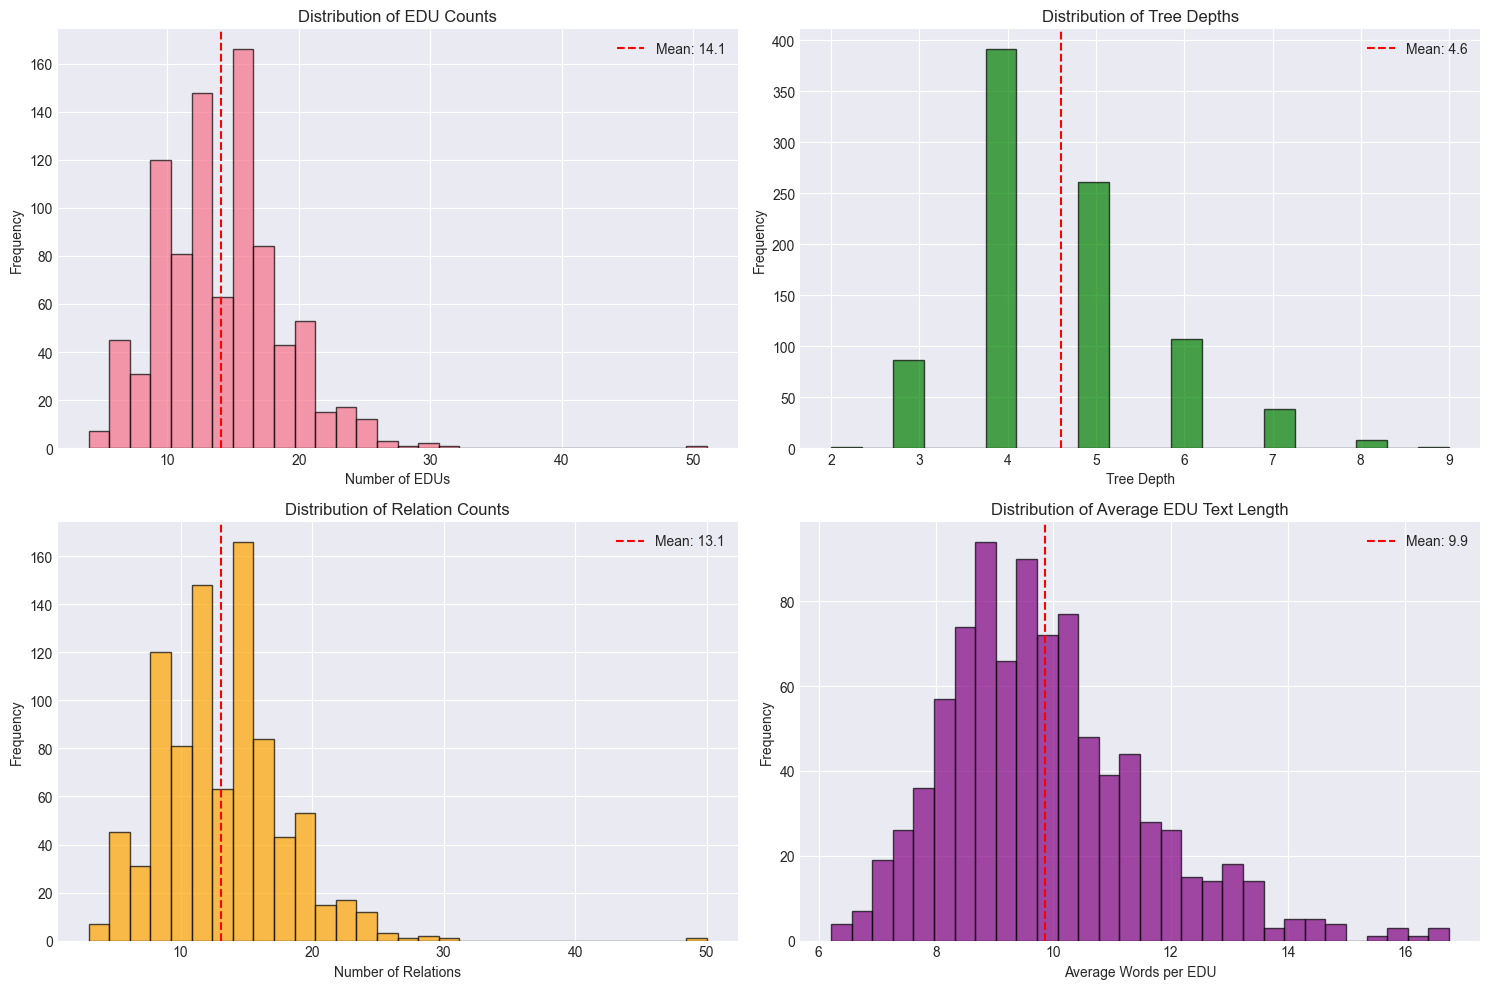

In [5]:
# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Number of EDUs
axes[0, 0].hist(stats_df['num_edus'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of EDUs')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of EDU Counts')
axes[0, 0].axvline(stats_df['num_edus'].mean(), color='red', linestyle='--', label=f'Mean: {stats_df["num_edus"].mean():.1f}')
axes[0, 0].legend()

# Tree depth
axes[0, 1].hist(stats_df['tree_depth'], bins=20, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Tree Depth')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Tree Depths')
axes[0, 1].axvline(stats_df['tree_depth'].mean(), color='red', linestyle='--', label=f'Mean: {stats_df["tree_depth"].mean():.1f}')
axes[0, 1].legend()

# Number of relations
axes[1, 0].hist(stats_df['num_relations'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Number of Relations')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Relation Counts')
axes[1, 0].axvline(stats_df['num_relations'].mean(), color='red', linestyle='--', label=f'Mean: {stats_df["num_relations"].mean():.1f}')
axes[1, 0].legend()

# Average text length
axes[1, 1].hist(stats_df['avg_text_length'], bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_xlabel('Average Words per EDU')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Average EDU Text Length')
axes[1, 1].axvline(stats_df['avg_text_length'].mean(), color='red', linestyle='--', label=f'Mean: {stats_df["avg_text_length"].mean():.1f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 3. EDU Analysis

In [6]:
def analyze_edus(trees: List[DiscourseTreeModel]) -> Dict:
    """
    Analyze EDU characteristics.
    """
    all_edu_lengths = []
    all_edu_texts = []
    
    for tree in trees:
        for edu in tree.edus:
            if edu.id != 0:  # Skip ROOT
                text = edu.text.strip()
                all_edu_texts.append(text)
                all_edu_lengths.append(len(text.split()))
    
    return {
        'lengths': all_edu_lengths,
        'texts': all_edu_texts,
        'total_edus': len(all_edu_lengths),
        'avg_length': np.mean(all_edu_lengths),
        'median_length': np.median(all_edu_lengths),
        'max_length': max(all_edu_lengths),
        'min_length': min(all_edu_lengths)
    }

edu_analysis = analyze_edus(all_trees)

print("\n" + "="*60)
print("EDU Analysis")
print("="*60)
print(f"Total EDUs: {edu_analysis['total_edus']:,}")
print(f"Average length: {edu_analysis['avg_length']:.2f} words")
print(f"Median length: {edu_analysis['median_length']:.0f} words")
print(f"Min length: {edu_analysis['min_length']} words")
print(f"Max length: {edu_analysis['max_length']} words")
print("="*60)


EDU Analysis
Total EDUs: 12,570
Average length: 9.64 words
Median length: 9 words
Min length: 1 words
Max length: 42 words


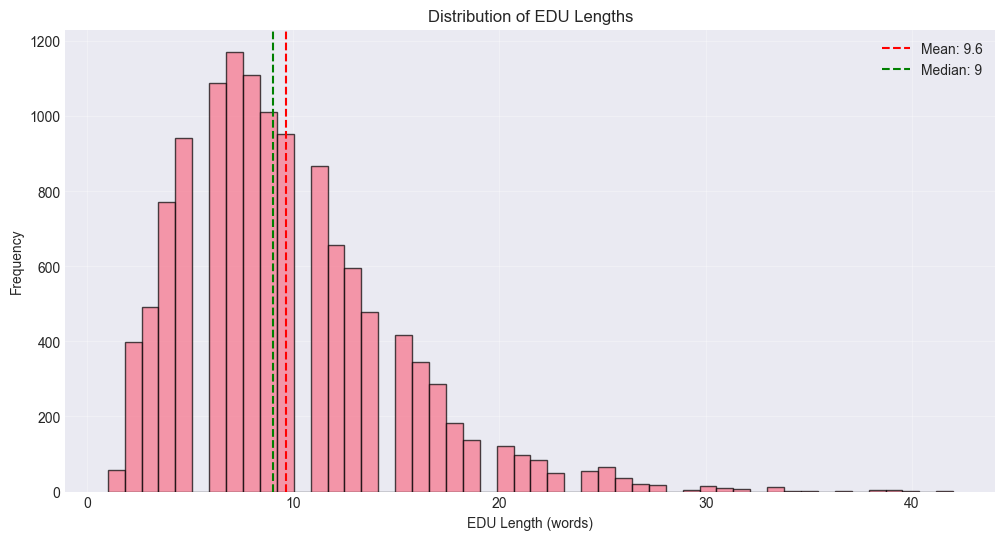

In [7]:
# EDU length distribution
plt.figure(figsize=(12, 6))
plt.hist(edu_analysis['lengths'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('EDU Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of EDU Lengths')
plt.axvline(edu_analysis['avg_length'], color='red', linestyle='--', label=f'Mean: {edu_analysis["avg_length"]:.1f}')
plt.axvline(edu_analysis['median_length'], color='green', linestyle='--', label=f'Median: {edu_analysis["median_length"]:.0f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# Show sample EDUs
print("\nSample EDUs (varying lengths):\n")
print("="*80)

# Sort by length and show samples
sorted_indices = np.argsort(edu_analysis['lengths'])
samples = [0, len(sorted_indices)//4, len(sorted_indices)//2, 3*len(sorted_indices)//4, -1]

for i in samples:
    idx = sorted_indices[i]
    text = edu_analysis['texts'][idx]
    length = edu_analysis['lengths'][idx]
    print(f"[{length} words] {text[:100]}..." if len(text) > 100 else f"[{length} words] {text}")
    print("-"*80)


Sample EDUs (varying lengths):

[1 words] suggesting
--------------------------------------------------------------------------------
[6 words] of reproducing sub-hierarchies of WordNet ,
--------------------------------------------------------------------------------
[9 words] such as co-reference resolution and discourse parsing . <S>
--------------------------------------------------------------------------------
[12 words] Slot filling remains very challenging over the past seven years . <S>
--------------------------------------------------------------------------------
[42 words] discourse segmentation and topic structure , appropriate choice of referent , the distinction betwee...
--------------------------------------------------------------------------------


## 4. Discourse Relations Analysis

In [9]:
def analyze_relations(trees: List[DiscourseTreeModel]) -> Dict:
    """
    Analyze discourse relation distribution.
    """
    relation_counts = Counter()
    
    for tree in trees:
        for edu in tree.edus:
            if edu.id != 0 and edu.relation != 'ROOT':  # Skip ROOT node and ROOT relation
                relation_counts[edu.relation] += 1
    
    return relation_counts

relation_counts = analyze_relations(all_trees)

# Create DataFrame
relations_df = pd.DataFrame([
    {'Relation': rel, 'Count': count, 'Percentage': count / sum(relation_counts.values()) * 100}
    for rel, count in relation_counts.most_common()
])

print("\n" + "="*70)
print("Discourse Relation Distribution")
print("="*70)
print(relations_df.to_string(index=False))
print("="*70)
print(f"\nTotal unique relations: {len(relation_counts)}")
print(f"Total relation instances: {sum(relation_counts.values()):,}")


Discourse Relation Distribution
         Relation  Count  Percentage
    elab-addition   3804   32.576860
       enablement    933    7.990066
       evaluation    920    7.878736
            joint    848    7.262139
      attribution    745    6.380063
     manner-means    651    5.575062
      elab-aspect    548    4.692986
          bg-goal    364    3.117239
         contrast    345    2.954526
        same-unit    319    2.731866
       bg-general    273    2.337929
      progression    242    2.072450
       bg-compare    235    2.012503
 elab-enum_member    188    1.610003
     elab-example    173    1.481545
elab-process_step    171    1.464417
           result    150    1.284577
         temporal    150    1.284577
        condition    146    1.250321
            cause    124    1.061917
       comparison    120    1.027661
       exp-reason    109    0.933459
     exp-evidence     58    0.496703
  elab-definition     32    0.274043
          summary     29    0.248351

Tota

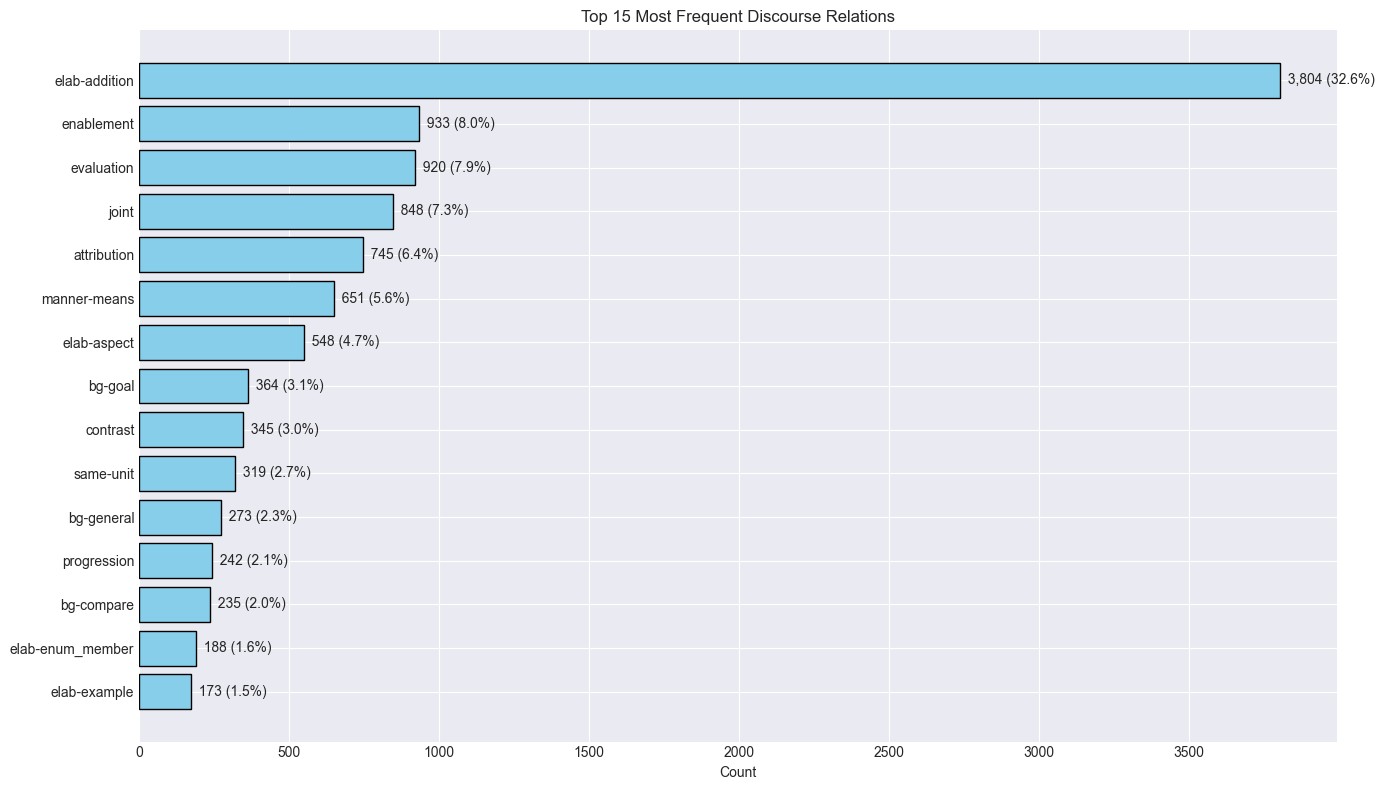

In [25]:
# Visualize top relations
top_n = 15
top_relations = relations_df.head(top_n)

plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(top_relations)), top_relations['Count'], color='skyblue', edgecolor='black')
plt.yticks(range(len(top_relations)), top_relations['Relation'])
plt.xlabel('Count')
plt.title(f'Top {top_n} Most Frequent Discourse Relations')
plt.gca().invert_yaxis()

# Add percentage labels
for i, (count, pct) in enumerate(zip(top_relations['Count'], top_relations['Percentage'])):
    plt.text(count, i, f'  {count:,} ({pct:.1f}%)', va='center')

plt.tight_layout()
plt.show()

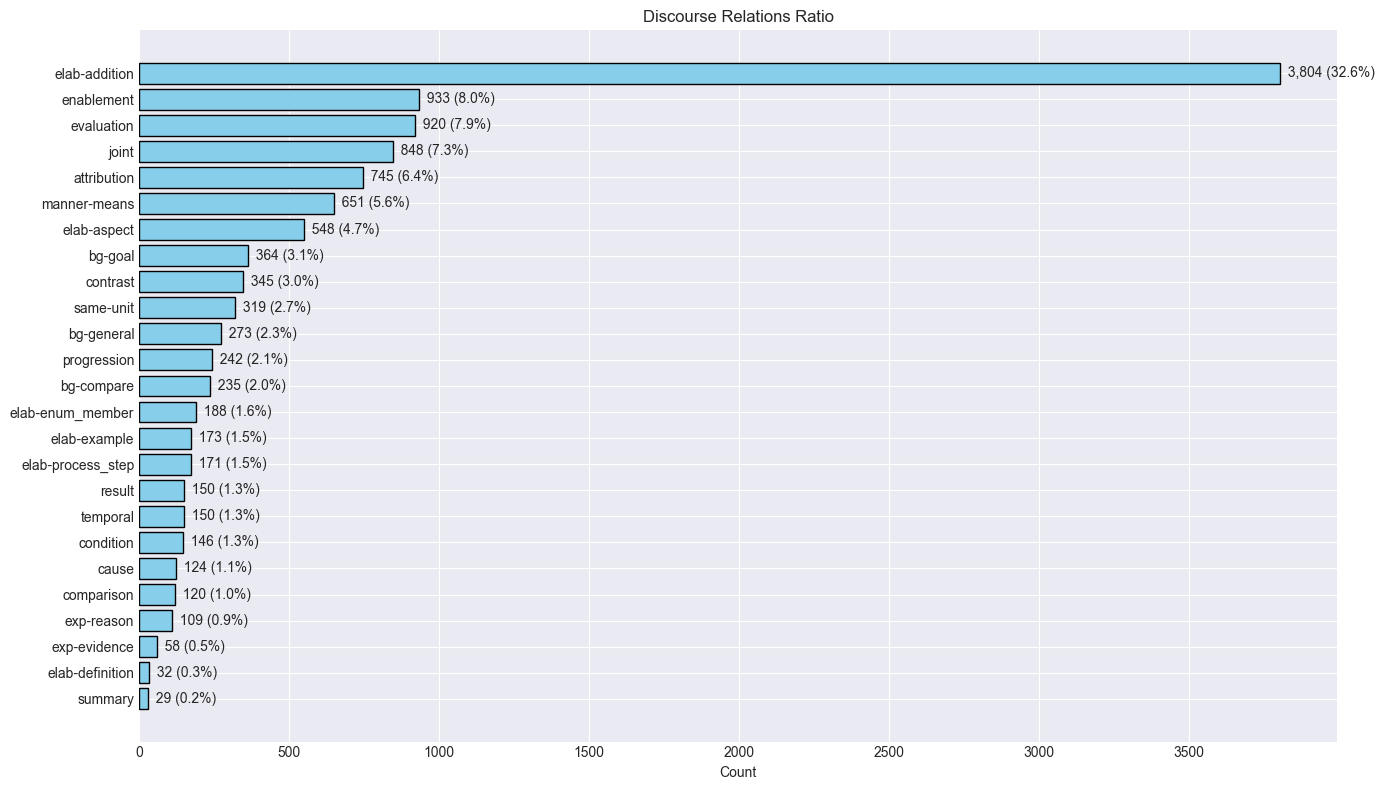

In [26]:
# Visualize top relations
top_n = 25
top_relations = relations_df.head(top_n)

plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(top_relations)), top_relations['Count'], color='skyblue', edgecolor='black')
plt.yticks(range(len(top_relations)), top_relations['Relation'])
plt.xlabel('Count')
plt.title(f'Discourse Relations Ratio')
plt.gca().invert_yaxis()

# Add percentage labels
for i, (count, pct) in enumerate(zip(top_relations['Count'], top_relations['Percentage'])):
    plt.text(count, i, f'  {count:,} ({pct:.1f}%)', va='center')

plt.tight_layout()
plt.show()

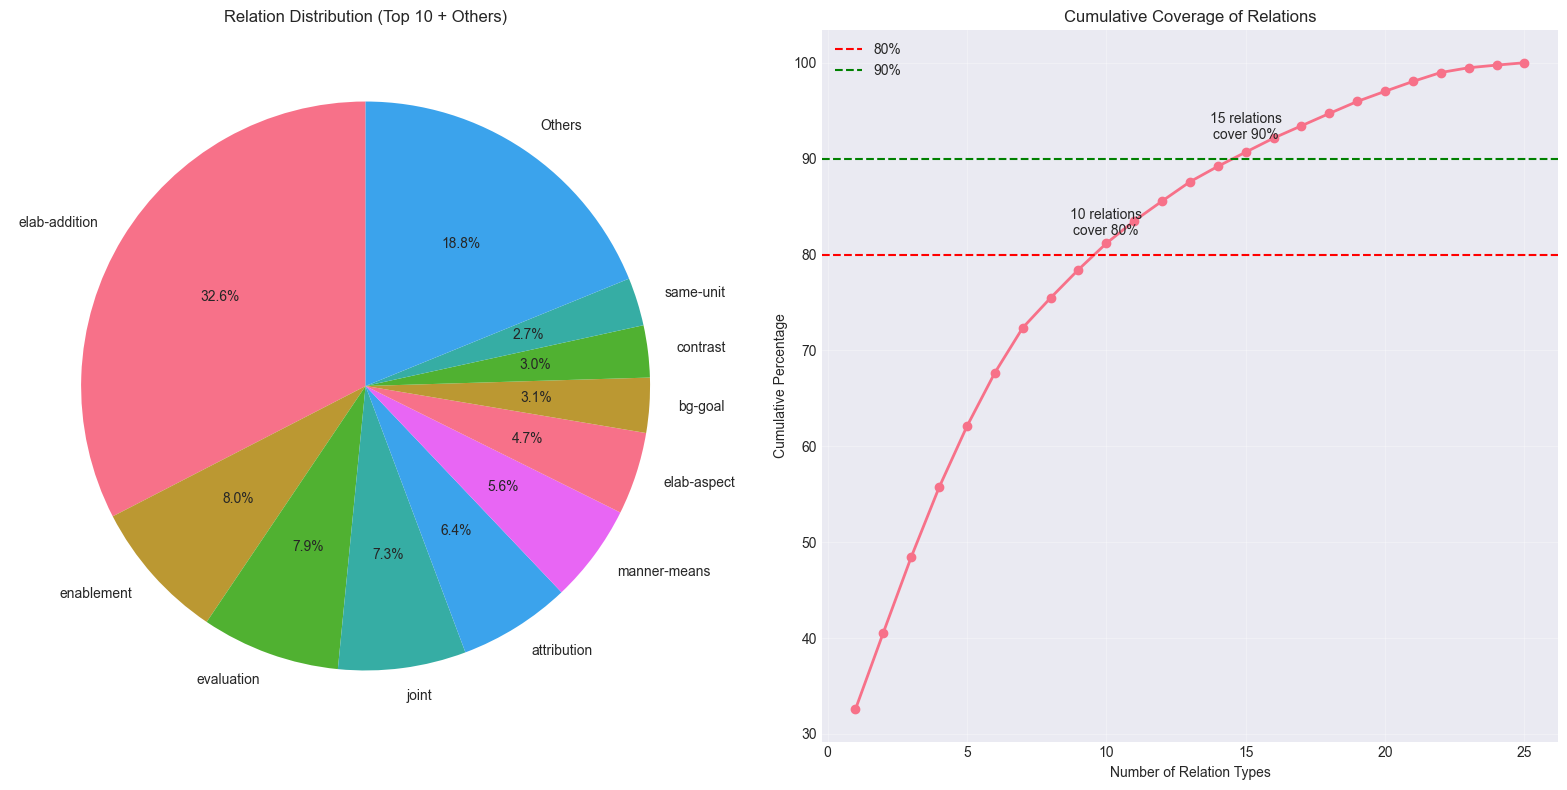


10 most frequent relations cover 80% of all instances
15 most frequent relations cover 90% of all instances


In [28]:
# Pie chart for relation distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Top 10 + Others
top_10 = relations_df.head(10)
others_count = relations_df.iloc[10:]['Count'].sum()

pie_data = list(top_10['Count']) + [others_count]
pie_labels = list(top_10['Relation']) + ['Others']

ax1.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
ax1.set_title('Relation Distribution (Top 10 + Others)')

# Cumulative percentage
cumsum = relations_df['Percentage'].cumsum()
ax2.plot(range(1, len(cumsum)+1), cumsum, marker='o', linewidth=2)
ax2.axhline(y=80, color='r', linestyle='--', label='80%')
ax2.axhline(y=90, color='g', linestyle='--', label='90%')
ax2.set_xlabel('Number of Relation Types')
ax2.set_ylabel('Cumulative Percentage')
ax2.set_title('Cumulative Coverage of Relations')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Add annotation for coverage
coverage_80 = (cumsum >= 80).argmax() + 1
coverage_90 = (cumsum >= 90).argmax() + 1
ax2.text(coverage_80, 82, f'{coverage_80} relations\ncover 80%', ha='center')
ax2.text(coverage_90, 92, f'{coverage_90} relations\ncover 90%', ha='center')

plt.tight_layout()
plt.show()

print(f"\n{coverage_80} most frequent relations cover 80% of all instances")
print(f"{coverage_90} most frequent relations cover 90% of all instances")

## 5. Tree Structure Analysis

In [29]:
def analyze_tree_structure(trees: List[DiscourseTreeModel]) -> Dict:
    """
    Analyze tree structural properties.
    """
    depths = []
    branching_factors = []
    non_projective_count = 0
    
    for tree in trees:
        # Depth
        max_depth = 0
        for edu in tree.edus:
            if edu.id == 0:
                continue
            depth = 0
            current_id = edu.parent
            while current_id != -1:
                depth += 1
                parent_edu = next((e for e in tree.edus if e.id == current_id), None)
                if parent_edu:
                    current_id = parent_edu.parent
                else:
                    break
            max_depth = max(max_depth, depth)
        depths.append(max_depth)
        
        # Branching factor
        children_counts = Counter()
        for edu in tree.edus:
            if edu.id != 0:
                children_counts[edu.parent] += 1
        
        if children_counts:
            branching_factors.append(np.mean(list(children_counts.values())))
        
        # Non-projectivity
        is_projective = True
        for edu in tree.edus:
            if edu.id == 0:
                continue
            head = edu.parent
            dep = edu.id
            
            # Check if any edge crosses this edge
            for other_edu in tree.edus:
                if other_edu.id == 0 or other_edu.id == dep:
                    continue
                other_head = other_edu.parent
                other_dep = other_edu.id
                
                # Check crossing
                if (min(head, dep) < min(other_head, other_dep) < max(head, dep) < max(other_head, other_dep)) or \
                   (min(other_head, other_dep) < min(head, dep) < max(other_head, other_dep) < max(head, dep)):
                    is_projective = False
                    break
            if not is_projective:
                break
        
        if not is_projective:
            non_projective_count += 1
    
    return {
        'depths': depths,
        'avg_depth': np.mean(depths),
        'max_depth': max(depths),
        'branching_factors': branching_factors,
        'avg_branching': np.mean(branching_factors),
        'non_projective_count': non_projective_count,
        'non_projective_ratio': non_projective_count / len(trees) * 100
    }

tree_analysis = analyze_tree_structure(all_trees)

print("\n" + "="*60)
print("Tree Structure Analysis")
print("="*60)
print(f"Average tree depth: {tree_analysis['avg_depth']:.2f}")
print(f"Maximum tree depth: {tree_analysis['max_depth']}")
print(f"Average branching factor: {tree_analysis['avg_branching']:.2f}")
print(f"Non-projective trees: {tree_analysis['non_projective_count']} ({tree_analysis['non_projective_ratio']:.1f}%)")
print("="*60)


Tree Structure Analysis
Average tree depth: 4.60
Maximum tree depth: 9
Average branching factor: 1.72
Non-projective trees: 26 (2.9%)


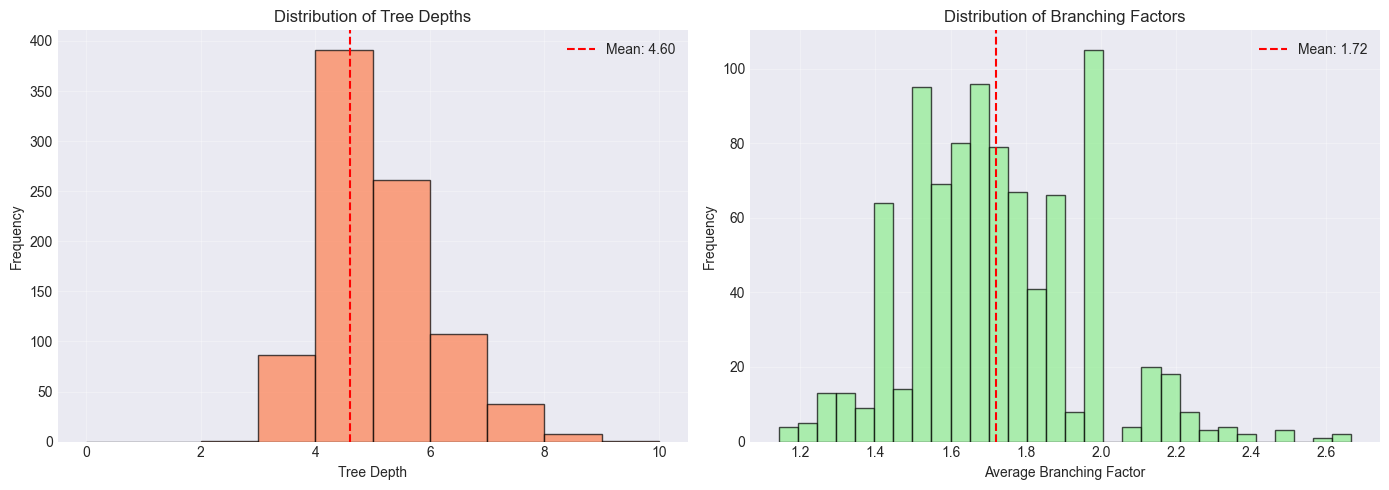

In [30]:
# Visualize tree structure properties
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Depth distribution
axes[0].hist(tree_analysis['depths'], bins=range(max(tree_analysis['depths'])+2), 
             edgecolor='black', alpha=0.7, color='coral')
axes[0].set_xlabel('Tree Depth')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Tree Depths')
axes[0].axvline(tree_analysis['avg_depth'], color='red', linestyle='--', 
                label=f'Mean: {tree_analysis["avg_depth"]:.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Branching factor distribution
axes[1].hist(tree_analysis['branching_factors'], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].set_xlabel('Average Branching Factor')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Branching Factors')
axes[1].axvline(tree_analysis['avg_branching'], color='red', linestyle='--', 
                label=f'Mean: {tree_analysis["avg_branching"]:.2f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Dependency Distance Analysis

In [31]:
def analyze_dependency_distance(trees: List[DiscourseTreeModel]) -> Dict:
    """
    Analyze dependency distance (distance between head and dependent).
    """
    distances = []
    distance_by_relation = defaultdict(list)
    
    for tree in trees:
        for edu in tree.edus:
            if edu.id == 0 or edu.relation == 'ROOT':
                continue
            
            distance = abs(edu.id - edu.parent) - 1  # Number of EDUs in between
            distances.append(distance)
            distance_by_relation[edu.relation].append(distance)
    
    # Compute statistics by relation
    relation_distance_stats = {}
    for relation, dists in distance_by_relation.items():
        relation_distance_stats[relation] = {
            'mean': np.mean(dists),
            'median': np.median(dists),
            'count': len(dists)
        }
    
    return {
        'distances': distances,
        'avg_distance': np.mean(distances),
        'median_distance': np.median(distances),
        'max_distance': max(distances),
        'by_relation': relation_distance_stats
    }

distance_analysis = analyze_dependency_distance(all_trees)

print("\n" + "="*60)
print("Dependency Distance Analysis")
print("="*60)
print(f"Average distance: {distance_analysis['avg_distance']:.2f} EDUs")
print(f"Median distance: {distance_analysis['median_distance']:.0f} EDUs")
print(f"Maximum distance: {distance_analysis['max_distance']} EDUs")
print("="*60)


Dependency Distance Analysis
Average distance: 1.44 EDUs
Median distance: 0 EDUs
Maximum distance: 25 EDUs


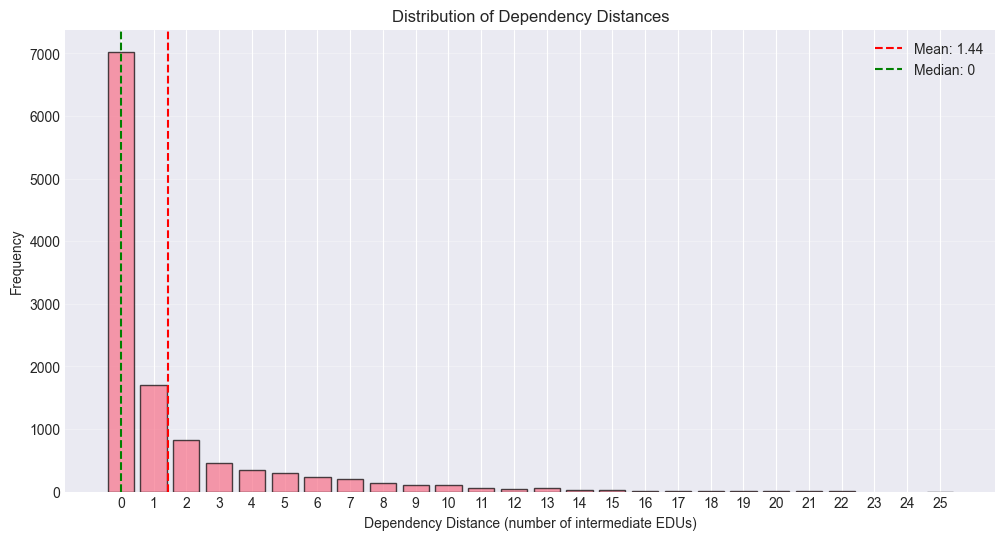


Distance Distribution:
----------------------------------------
Distance  0: 7,027 ( 60.2%) - Cumulative:  60.2%
Distance  1: 1,709 ( 14.6%) - Cumulative:  74.8%
Distance  2:   821 (  7.0%) - Cumulative:  81.8%
Distance  3:   458 (  3.9%) - Cumulative:  85.8%
Distance  4:   345 (  3.0%) - Cumulative:  88.7%
Distance  5:   289 (  2.5%) - Cumulative:  91.2%
Distance  6:   227 (  1.9%) - Cumulative:  93.1%
Distance  7:   197 (  1.7%) - Cumulative:  94.8%
Distance  8:   143 (  1.2%) - Cumulative:  96.1%
Distance  9:   106 (  0.9%) - Cumulative:  97.0%
Distance 10:    98 (  0.8%) - Cumulative:  97.8%


In [32]:
# Dependency distance distribution
plt.figure(figsize=(12, 6))

# Count frequencies
distance_counts = Counter(distance_analysis['distances'])
distances_sorted = sorted(distance_counts.keys())
counts = [distance_counts[d] for d in distances_sorted]

plt.bar(distances_sorted, counts, edgecolor='black', alpha=0.7)
plt.xlabel('Dependency Distance (number of intermediate EDUs)')
plt.ylabel('Frequency')
plt.title('Distribution of Dependency Distances')
plt.axvline(distance_analysis['avg_distance'], color='red', linestyle='--', 
            label=f'Mean: {distance_analysis["avg_distance"]:.2f}')
plt.axvline(distance_analysis['median_distance'], color='green', linestyle='--', 
            label=f'Median: {distance_analysis["median_distance"]:.0f}')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(range(0, max(distances_sorted)+1, max(1, max(distances_sorted)//20)))
plt.show()

# Print percentage breakdown
total = len(distance_analysis['distances'])
print("\nDistance Distribution:")
print("-" * 40)
cumulative = 0
for dist in range(min(11, max(distances_sorted) + 1)):
    count = distance_counts.get(dist, 0)
    pct = count / total * 100
    cumulative += pct
    print(f"Distance {dist:2d}: {count:5,} ({pct:5.1f}%) - Cumulative: {cumulative:5.1f}%")

In [33]:
# Top relations with longest average distance
relation_dist_df = pd.DataFrame([
    {
        'Relation': rel,
        'Mean Distance': stats['mean'],
        'Median Distance': stats['median'],
        'Count': stats['count']
    }
    for rel, stats in distance_analysis['by_relation'].items()
    if stats['count'] >= 10  # Only relations with at least 10 instances
]).sort_values('Mean Distance', ascending=False)

print("\nTop 10 Relations with Longest Average Distance:")
print("="*70)
print(relation_dist_df.head(10).to_string(index=False))
print("\nTop 10 Relations with Shortest Average Distance:")
print("="*70)
print(relation_dist_df.tail(10).to_string(index=False))


Top 10 Relations with Longest Average Distance:
         Relation  Mean Distance  Median Distance  Count
       evaluation       7.264130              7.0    920
          summary       6.793103              5.0     29
      elab-aspect       4.082117              3.0    548
elab-process_step       4.035088              3.0    171
          bg-goal       2.796703              2.0    364
       bg-compare       2.570213              2.0    235
      progression       1.318182              1.0    242
        same-unit       1.109718              1.0    319
           result       1.100000              1.0    150
     exp-evidence       1.017241              1.0     58

Top 10 Relations with Shortest Average Distance:
        Relation  Mean Distance  Median Distance  Count
    manner-means       0.477727              0.0    651
elab-enum_member       0.436170              0.0    188
           joint       0.426887              0.0    848
      exp-reason       0.394495              0.0  

## 7. Relation Co-occurrence Analysis

In [34]:
def analyze_relation_cooccurrence(trees: List[DiscourseTreeModel], top_n: int = 15) -> pd.DataFrame:
    """
    Analyze which relations frequently co-occur in the same tree.
    """
    # Get top N relations
    all_relations = []
    for tree in trees:
        for edu in tree.edus:
            if edu.id != 0 and edu.relation != 'ROOT':
                all_relations.append(edu.relation)
    
    top_relations = [rel for rel, _ in Counter(all_relations).most_common(top_n)]
    
    # Build co-occurrence matrix
    cooccurrence = {rel: Counter() for rel in top_relations}
    
    for tree in trees:
        tree_relations = set()
        for edu in tree.edus:
            if edu.id != 0 and edu.relation != 'ROOT' and edu.relation in top_relations:
                tree_relations.add(edu.relation)
        
        # Update co-occurrence counts
        for rel1 in tree_relations:
            for rel2 in tree_relations:
                if rel1 != rel2:
                    cooccurrence[rel1][rel2] += 1
    
    # Convert to DataFrame
    matrix = pd.DataFrame(0, index=top_relations, columns=top_relations)
    for rel1 in top_relations:
        for rel2 in top_relations:
            matrix.loc[rel1, rel2] = cooccurrence[rel1][rel2]
    
    return matrix

cooccurrence_matrix = analyze_relation_cooccurrence(all_trees, top_n=15)

print("\nRelation Co-occurrence Matrix (Top 15 relations)")
print("Values represent: number of trees where both relations appear together")


Relation Co-occurrence Matrix (Top 15 relations)
Values represent: number of trees where both relations appear together


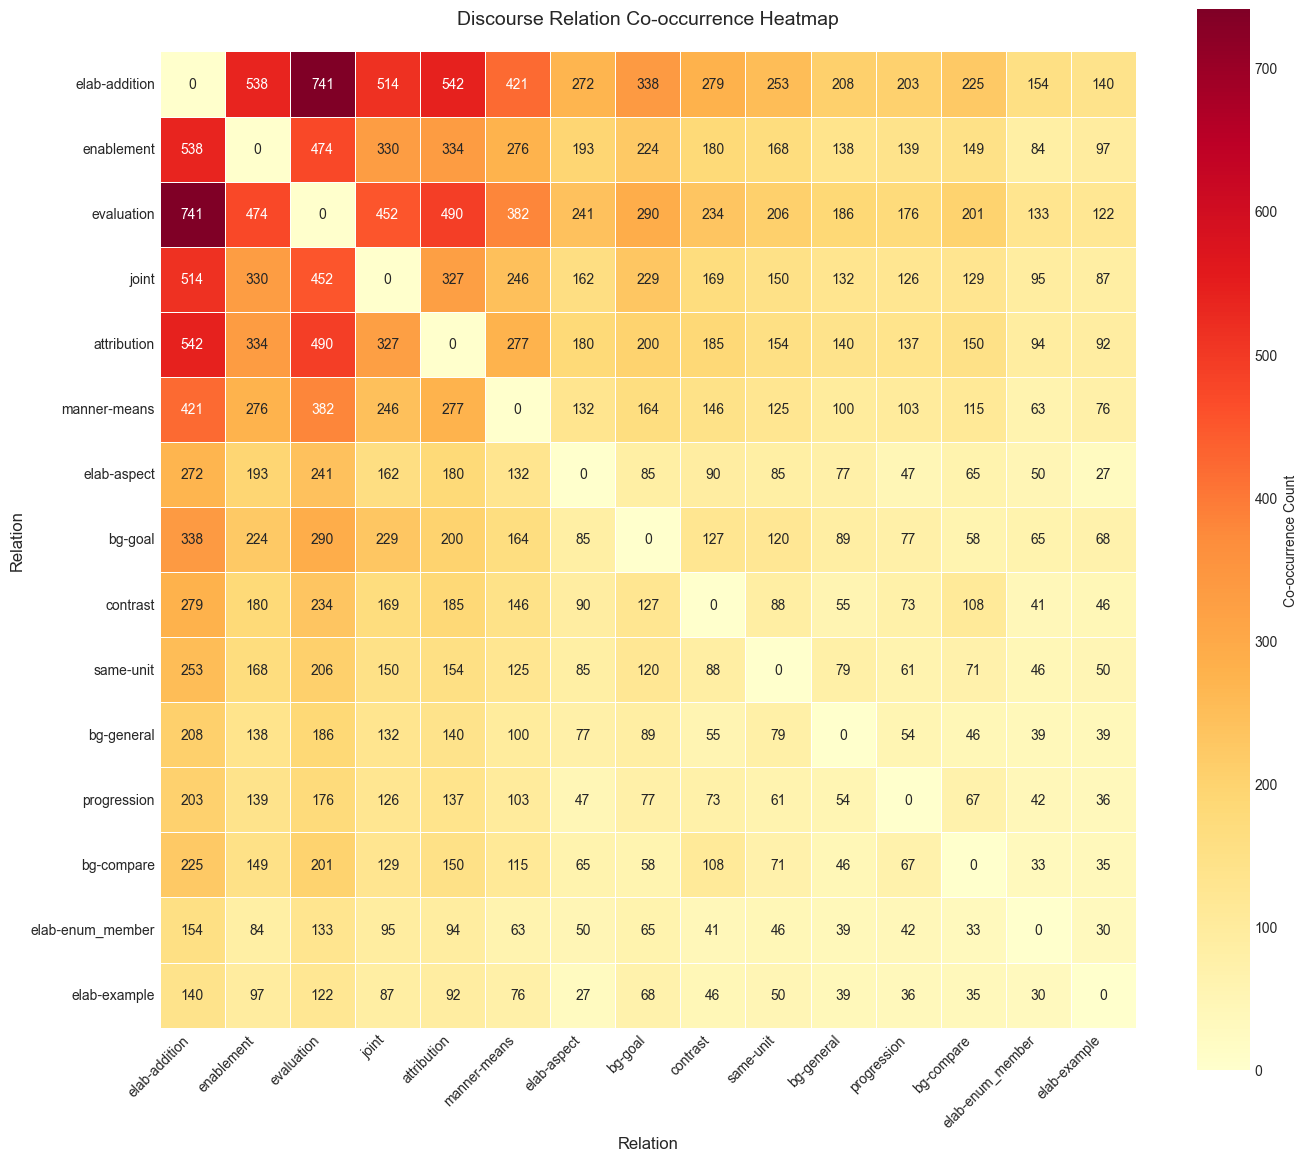

In [35]:
# Visualize co-occurrence as heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cooccurrence_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            square=True, linewidths=0.5, cbar_kws={'label': 'Co-occurrence Count'})
plt.title('Discourse Relation Co-occurrence Heatmap', fontsize=14, pad=20)
plt.xlabel('Relation', fontsize=12)
plt.ylabel('Relation', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 8. Split Comparison

In [36]:
def compare_splits(train_trees: List[DiscourseTreeModel], 
                   test_trees: List[DiscourseTreeModel]) -> pd.DataFrame:
    """
    Compare statistics between train and test splits.
    """
    def get_stats(trees):
        # EDU counts
        edu_counts = [len([e for e in tree.edus if e.id != 0]) for tree in trees]
        
        # Relation counts
        relation_counts = Counter()
        for tree in trees:
            for edu in tree.edus:
                if edu.id != 0 and edu.relation != 'ROOT':
                    relation_counts[edu.relation] += 1
        
        return {
            'Num Trees': len(trees),
            'Avg EDUs': np.mean(edu_counts),
            'Total EDUs': sum(edu_counts),
            'Unique Relations': len(relation_counts),
            'Total Relations': sum(relation_counts.values())
        }
    
    train_stats = get_stats(train_trees)
    test_stats = get_stats(test_trees)
    all_stats = get_stats(train_trees + test_trees)
    
    df = pd.DataFrame({
        'Train': train_stats,
        'Test': test_stats,
        'All': all_stats
    })
    
    return df.T

split_comparison = compare_splits(train_trees, test_trees)

print("\n" + "="*70)
print("Split Comparison")
print("="*70)
print(split_comparison)
print("="*70)


Split Comparison
       Num Trees   Avg EDUs  Total EDUs  Unique Relations  Total Relations
Train      742.0  14.106469     10467.0              25.0           9725.0
Test       151.0  13.927152      2103.0              25.0           1952.0
All        893.0  14.076148     12570.0              25.0          11677.0


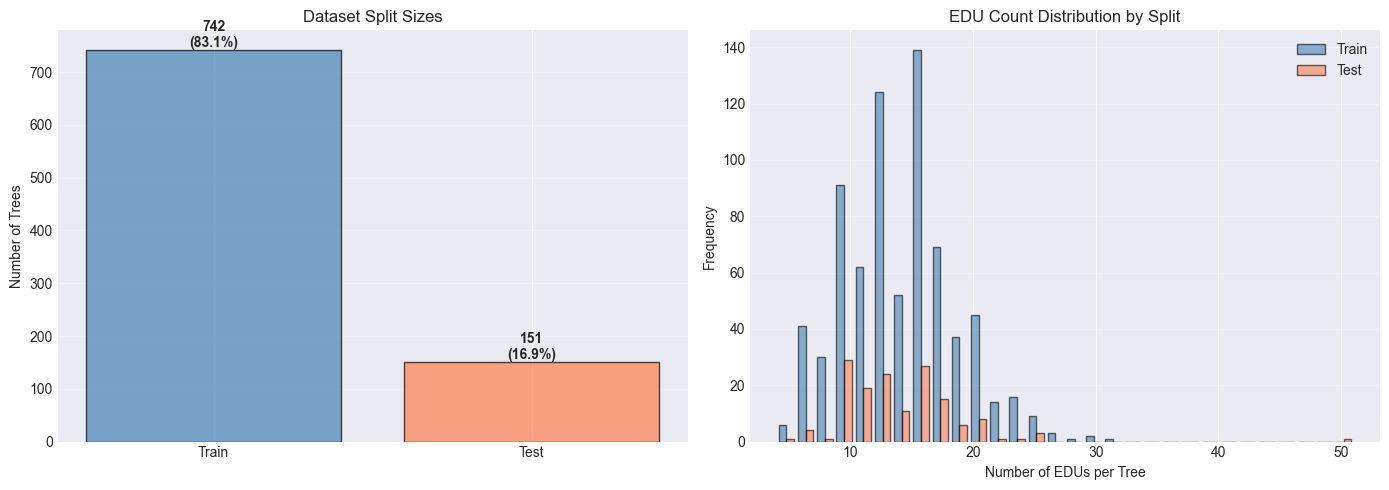

In [37]:
# Visualize split comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Number of trees
splits = ['Train', 'Test']
tree_counts = [len(train_trees), len(test_trees)]
colors = ['steelblue', 'coral']

axes[0].bar(splits, tree_counts, color=colors, edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Number of Trees')
axes[0].set_title('Dataset Split Sizes')
axes[0].grid(True, alpha=0.3, axis='y')

for i, (split, count) in enumerate(zip(splits, tree_counts)):
    axes[0].text(i, count, f'{count}\n({count/sum(tree_counts)*100:.1f}%)', 
                 ha='center', va='bottom', fontweight='bold')

# EDU distributions
train_edu_counts = [len([e for e in tree.edus if e.id != 0]) for tree in train_trees]
test_edu_counts = [len([e for e in tree.edus if e.id != 0]) for tree in test_trees]

axes[1].hist([train_edu_counts, test_edu_counts], bins=30, label=['Train', 'Test'], 
             color=colors, alpha=0.6, edgecolor='black')
axes[1].set_xlabel('Number of EDUs per Tree')
axes[1].set_ylabel('Frequency')
axes[1].set_title('EDU Count Distribution by Split')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Sample Tree Visualization

In [38]:
def print_tree_structure(tree: DiscourseTreeModel, max_text_len: int = 60):
    """
    Print a tree structure in readable format.
    """
    # Build adjacency list
    children = defaultdict(list)
    for edu in tree.edus:
        if edu.parent != -1:
            children[edu.parent].append(edu)
    
    # Print tree
    def print_subtree(edu_id, prefix="", is_last=True):
        edu = next(e for e in tree.edus if e.id == edu_id)
        
        # Format text
        text = edu.text.strip()
        if len(text) > max_text_len:
            text = text[:max_text_len] + "..."
        
        # Print current node
        connector = "└── " if is_last else "├── "
        if edu_id == 0:
            print(f"{text}")
        else:
            print(f"{prefix}{connector}[{edu.relation}] {text}")
        
        # Print children
        child_list = sorted(children[edu_id], key=lambda e: e.id)
        for i, child in enumerate(child_list):
            is_last_child = (i == len(child_list) - 1)
            extension = "    " if is_last else "│   "
            print_subtree(child.id, prefix + extension, is_last_child)
    
    print_subtree(0)

# Show a sample tree
print("\n" + "="*80)
print("Sample Tree Structure")
print("="*80)

# Find a tree with moderate complexity
sample_tree = sorted(all_trees, key=lambda t: len(t.edus))[len(all_trees)//2]

print(f"\nTree with {len([e for e in sample_tree.edus if e.id != 0])} EDUs:\n")
print_tree_structure(sample_tree)
print("\n" + "="*80)


Sample Tree Structure

Tree with 14 EDUs:

ROOT
    └── [ROOT] In this work we studied the performance of two very popular ...
        ├── [bg-goal] Word alignment
        │   ├── [elab-addition] using recency-vector based approach
        │   ├── [same-unit] has recently become popular . <S>
        │   ├── [elab-addition] they perform well
        │   │   ├── [attribution] One major advantage of these techniques is that
        │   │   ├── [contrast] unlike other approaches
        │   │   └── [contrast] even if the size of the parallel corpora is small . <S>
        │   └── [progression] This makes these algorithms worth-studying for languages
        │       └── [elab-addition] where resources are scarce . <S>
        ├── [elab-enum_member] proposed in ( Fung and McKeown , 1994 ) and ( Somers , 1998 ...
        │   └── [contrast] But performance of the above algorithms was not found to be ...
        │       └── [contrast] However , subsequent addition of some new constraints impr

## Summary

In [39]:
print("\n" + "="*80)
print("SciDTB Dataset Summary")
print("="*80)
print(f"Total abstracts: {len(all_trees):,}")
print(f"  - Training: {len(train_trees):,} ({len(train_trees)/len(all_trees)*100:.1f}%)")
print(f"  - Test: {len(test_trees):,} ({len(test_trees)/len(all_trees)*100:.1f}%)")
print()
print(f"Total EDUs: {edu_analysis['total_edus']:,}")
print(f"  - Average per tree: {edu_analysis['total_edus']/len(all_trees):.1f}")
print(f"  - Average length: {edu_analysis['avg_length']:.1f} words")
print()
print(f"Discourse relations:")
print(f"  - Unique types: {len(relation_counts)}")
print(f"  - Total instances: {sum(relation_counts.values()):,}")
print(f"  - Most common: {relations_df.iloc[0]['Relation']} ({relations_df.iloc[0]['Percentage']:.1f}%)")
print()
print(f"Tree structure:")
print(f"  - Average depth: {tree_analysis['avg_depth']:.1f}")
print(f"  - Average branching: {tree_analysis['avg_branching']:.2f}")
print(f"  - Non-projective: {tree_analysis['non_projective_ratio']:.1f}%")
print()
print(f"Dependency distance:")
print(f"  - Average: {distance_analysis['avg_distance']:.2f} EDUs")
print(f"  - Median: {distance_analysis['median_distance']:.0f} EDUs")
print(f"  - Adjacent (0 EDUs between): {Counter(distance_analysis['distances'])[0]/len(distance_analysis['distances'])*100:.1f}%")
print("="*80)


SciDTB Dataset Summary
Total abstracts: 893
  - Training: 742 (83.1%)
  - Test: 151 (16.9%)

Total EDUs: 12,570
  - Average per tree: 14.1
  - Average length: 9.6 words

Discourse relations:
  - Unique types: 25
  - Total instances: 11,677
  - Most common: elab-addition (32.6%)

Tree structure:
  - Average depth: 4.6
  - Average branching: 1.72
  - Non-projective: 2.9%

Dependency distance:
  - Average: 1.44 EDUs
  - Median: 0 EDUs
  - Adjacent (0 EDUs between): 60.2%
